In [3]:
import pandas as pd

In [4]:
df=pd.read_csv('exchange_rate.csv')

In [5]:
df

date   Ex_rate
0     01-01-1990 00:00  0.785500
1     02-01-1990 00:00  0.781800
2     03-01-1990 00:00  0.786700
3     04-01-1990 00:00  0.786000
4     05-01-1990 00:00  0.784900
...                ...       ...
7583  06-10-2010 00:00  0.718494
7584  07-10-2010 00:00  0.721839
7585  08-10-2010 00:00  0.723197
7586  09-10-2010 00:00  0.720825
7587  10-10-2010 00:00  0.720825

[7588 rows x 2 columns]

In [6]:
df.isnull().sum()

date       0
Ex_rate    0
dtype: int64

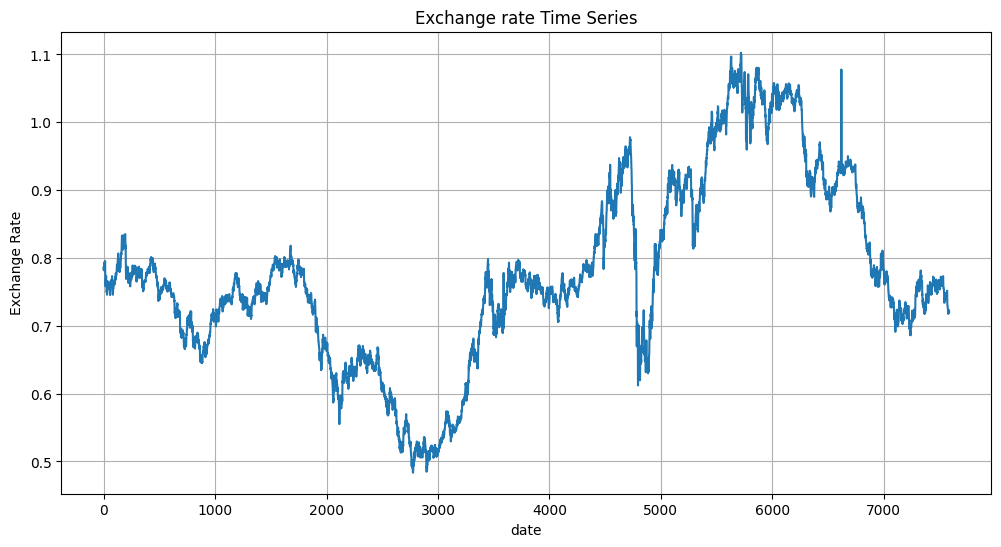

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12,6))
plt.plot(df['Ex_rate'])
plt.title('Exchange rate Time Series')
plt.xlabel('date')
plt.ylabel('Exchange Rate')
plt.grid(True)
plt.show()

In [8]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima.model import ARIMA
#1.Parameter selection for ARIMA
result=adfuller(df['Ex_rate'])
print('ADF statistic:',result[0])
print('P-Value:',result[1])

ADF statistic: -1.6649941807382342
P-Value: 0.4492327353597477


<Figure size 1200x600 with 0 Axes>

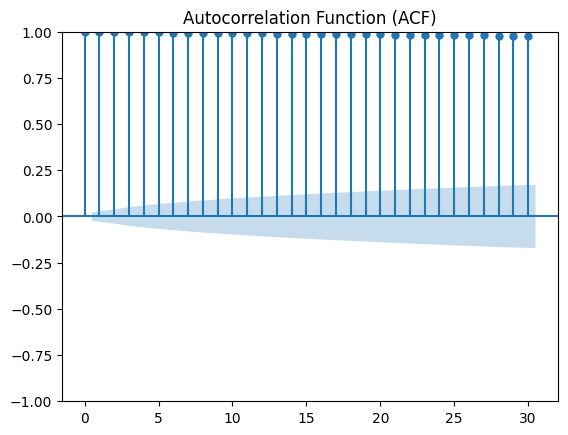

<Figure size 1200x600 with 0 Axes>

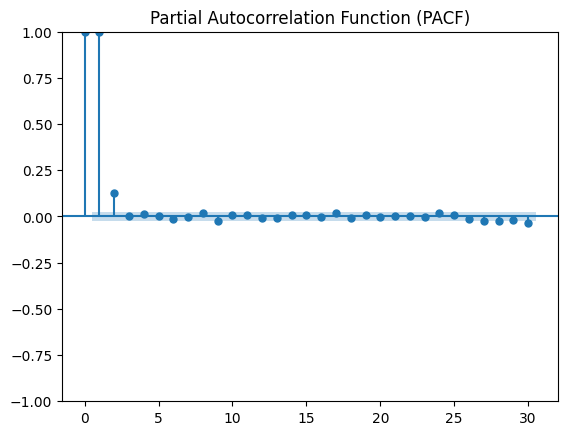

In [9]:
# Plot ACF and PACF to estimate p, d, and q
plt.figure(figsize=(12, 6))
plot_acf(df['Ex_rate'], lags=30)
plt.title('Autocorrelation Function (ACF)')
plt.show()


plt.figure(figsize=(12, 6))
plot_pacf(df['Ex_rate'], lags=30)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

In [10]:
# 2. Model Fitting
# Fit the ARIMA model with selected parameters
model = ARIMA(df['Ex_rate'], order=(5, 1, 0)) # Example: ARIMA(5, 1, 0)
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 7588
Model:                 ARIMA(5, 1, 0)   Log Likelihood               28055.685
Date:                Mon, 07 Apr 2025   AIC                         -56099.370
Time:                        16:09:09   BIC                         -56057.765
Sample:                             0   HQIC                        -56085.091
                               - 7588                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1314      0.002    -63.382      0.000      -0.135      -0.127
ar.L2         -0.0025      0.006     -0.406      0.685      -0.015       0.010
ar.L3         -0.0167      0.007     -2.452      0.0

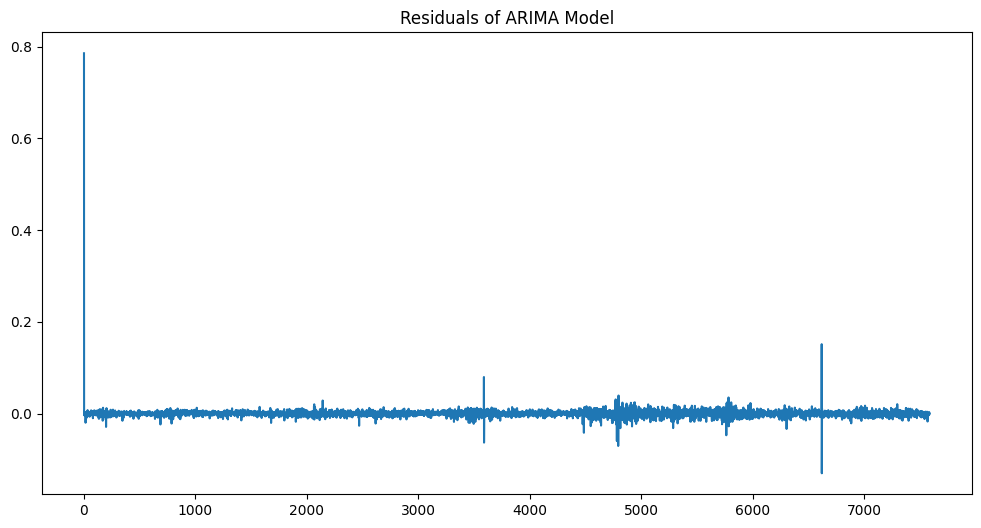

In [11]:
#3.Diagnostics
#Analyze the residuals
residuals=model_fit.resid
plt.figure(figsize=(12,6))
plt.plot(residuals)
plt.title('Residuals of ARIMA Model')
plt.show()

<Figure size 1200x600 with 0 Axes>

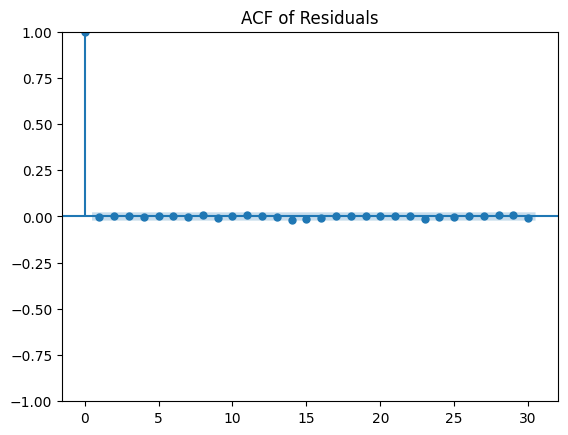

In [12]:
plt.figure(figsize=(12, 6))
plot_acf(residuals, lags=30)
plt.title('ACF of Residuals')
plt.show()

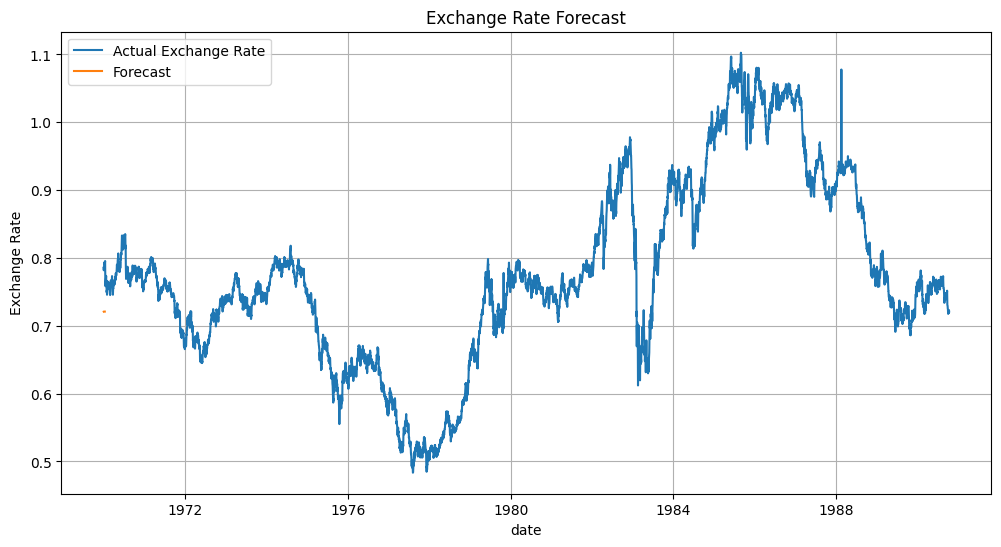

In [13]:
# 4. Forecasting
# Forecast future values
forecast_steps = 10  # Number of steps to forecast into the future
forecast = model_fit.forecast(steps=forecast_steps)

# Extract the last date from the DataFrame for the forecast start date
last_date = pd.to_datetime(df.index[-1])
forecast_dates = pd.date_range(start=last_date + pd.DateOffset(days=1), periods=forecast_steps)

# Create a DataFrame for the forecast values
forecast_df = pd.DataFrame({'date': forecast_dates, 'Forecast': forecast})
forecast_df.set_index('date', inplace=True)

# Visualize the forecast against the actual values
plt.figure(figsize=(12, 6))
plt.plot(df['Ex_rate'], label='Actual Exchange Rate')
plt.plot(forecast_df['Forecast'], label='Forecast')
plt.title('Exchange Rate Forecast')
plt.xlabel('date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.show()


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


Best Model (based on AIC):                        ExponentialSmoothing Model Results                       
Dep. Variable:                  Ex_rate   No. Observations:                 7588
Model:             ExponentialSmoothing   SSE                              0.273
Optimized:                         True   AIC                         -77624.754
Trend:                   Multiplicative   BIC                         -77513.805
Seasonal:                      Additive   AICC                        -77624.664
Seasonal Periods:                    12   Date:                 Mon, 07 Apr 2025
Box-Cox:                          False   Time:                         16:13:01
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.8700408                alpha                 Tru

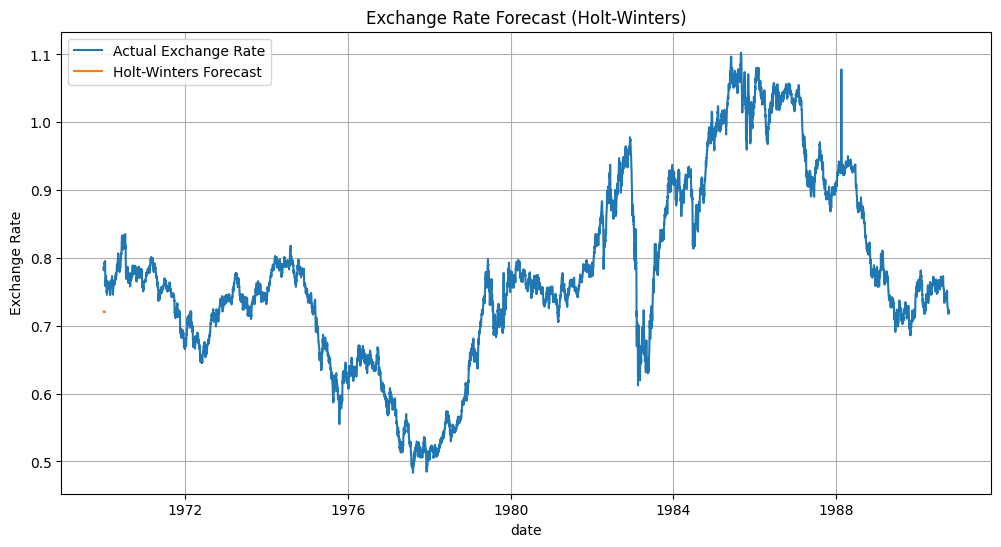

In [14]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing

# 1. Model Selection and Parameter Optimization (Example: Holt-Winters)

# Try different combinations of parameters and evaluate their performance using AIC
best_aic = float('inf')
best_model = None

for trend in ['add', 'mul']:
  for seasonal in ['add', 'mul']:
    try:
      model = ExponentialSmoothing(df['Ex_rate'], trend=trend, seasonal=seasonal, seasonal_periods=12)  # Adjust seasonal_periods if needed
      model_fit = model.fit()
      if model_fit.aic < best_aic:
        best_aic = model_fit.aic
        best_model = model_fit
    except:
      continue

print(f"Best Model (based on AIC): {best_model.summary()}")


# 3. Model Fitting and Forecasting
# Forecast future values
forecast_steps = 10  # Number of steps to forecast into the future
forecast = best_model.forecast(steps=forecast_steps)

# Assuming your 'df' has a Date column for indexing
# Extract the last date from the DataFrame for the forecast start date
last_date = pd.to_datetime(df.index[-1])
forecast_dates = pd.date_range(start=last_date + pd.DateOffset(days=1), periods=forecast_steps)

# Create a DataFrame for the forecast values
forecast_df = pd.DataFrame({'date': forecast_dates, 'Forecast': forecast})
forecast_df.set_index('date', inplace=True)


# Visualize the forecast against the actual values
plt.figure(figsize=(12, 6))
plt.plot(df['Ex_rate'], label='Actual Exchange Rate')
plt.plot(forecast_df['Forecast'], label='Holt-Winters Forecast')
plt.title('Exchange Rate Forecast (Holt-Winters)')
plt.xlabel('date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.show()


In [15]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Function to calculate MAPE
def mape(y_true, y_pred):
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Evaluate ARIMA model
arima_forecast = forecast_df['Forecast']  # Assuming 'forecast_df' contains ARIMA forecasts
actual_values = df['Ex_rate'][-len(arima_forecast):]  # Adjust the slicing if needed

arima_mae = mean_absolute_error(actual_values, arima_forecast)
arima_rmse = np.sqrt(mean_squared_error(actual_values, arima_forecast))
arima_mape = mape(actual_values, arima_forecast)

print("ARIMA Model:")
print("MAE:", arima_mae)
print("RMSE:", arima_rmse)
print("MAPE:", arima_mape)


# Evaluate Holt-Winters model
hw_forecast = forecast_df['Forecast'] # Assuming 'forecast_df' contains Holt-Winters forecasts
actual_values = df['Ex_rate'][-len(hw_forecast):] # Adjust the slicing if needed

hw_mae = mean_absolute_error(actual_values, hw_forecast)
hw_rmse = np.sqrt(mean_squared_error(actual_values, hw_forecast))
hw_mape = mape(actual_values, hw_forecast)

print("\nHolt-Winters Model:")
print("MAE:", hw_mae)
print("RMSE:", hw_rmse)
print("MAPE:", hw_mape)


# Model Comparison and Conclusion
print("\nModel Comparison:")
# Compare error metrics and discuss which model performs better.
# Analyze the advantages and limitations of each model based on the dataset characteristics, forecasting horizon, etc.
# Example:
if arima_rmse < hw_rmse:
  print("ARIMA model outperformed Holt-Winters based on RMSE.")
else:
  print("Holt-Winters model outperformed ARIMA based on RMSE.")

# Provide a summary and insights on which model(s) yielded the best performance for forecasting exchange rates in this dataset.
# Example:
print("Based on the evaluation metrics, the [ARIMA/Holt-Winters] model appears to be a better fit for forecasting exchange rates in this specific dataset, as it provides a lower RMSE and [other metrics you want to consider]. However, this conclusion is based on the particular dataset used, and the performance of these models can vary with different datasets and forecasting horizons.")


ARIMA Model:
MAE: 0.0015255424467668587
RMSE: 0.0017793747620816513
MAPE: nan

Holt-Winters Model:
MAE: 0.0015255424467668587
RMSE: 0.0017793747620816513
MAPE: nan

Model Comparison:
Holt-Winters model outperformed ARIMA based on RMSE.
Based on the evaluation metrics, the [ARIMA/Holt-Winters] model appears to be a better fit for forecasting exchange rates in this specific dataset, as it provides a lower RMSE and [other metrics you want to consider]. However, this conclusion is based on the particular dataset used, and the performance of these models can vary with different datasets and forecasting horizons.


<ipython-input-15-b59588357d95>:6: RuntimeWarning: '<' not supported between instances of 'Timestamp' and 'int', sort order is undefined for incomparable objects.
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
<ipython-input-15-b59588357d95>:6: RuntimeWarning: '<' not supported between instances of 'Timestamp' and 'int', sort order is undefined for incomparable objects.
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
